In [1]:
import os 

import pandas as pd
import s3fs
import mlflow

fs = s3fs.S3FileSystem(
    client_kwargs={
        "endpoint_url":'http://minio.minio:80',
    },
    key='admin',                       
    secret='admin123',                 
    use_ssl=False,                     
)

parquet_files = fs.glob('dataset/weather_data_random_preprocessing/*.parquet')

df = pd.concat([pd.read_parquet(f, filesystem=fs) for f in parquet_files])
df_test = pd.read_csv('dataset/weather_data_recent_test.csv')

In [2]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 960 entries, 0 to 959
Data columns (total 13 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Hour                      960 non-null    Int64  
 1   Temperature(C)            960 non-null    float64
 2   Humidity(%)               960 non-null    Int64  
 3   Wind speed (m/s)          960 non-null    float64
 4   Visibility (10m)          960 non-null    float64
 5   Dew point temperature(C)  960 non-null    float64
 6   Rainfall(mm)              960 non-null    float64
 7   Snowfall (cm)             960 non-null    float64
 8   Seasons                   720 non-null    float64
 9   Holiday                   960 non-null    Int64  
 10  hour diff                 960 non-null    float64
 11  Functioning Day           960 non-null    Int64  
 12  rental_cnt                960 non-null    Int64  
dtypes: Int64(5), float64(8)
memory usage: 102.3 KB


In [3]:
import mlflow
import mlflow.sklearn
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from xgboost import XGBRegressor
import numpy as np
import pandas as pd

import os

# MLflow 실험 설정
HOST = "http://mlflow.mlflow:5000"
EXPREIMENT_NAME = "Manual Seoul Bike Rental Prediction"

os.environ['AWS_ACCESS_KEY_ID'] = 'admin'
os.environ['AWS_SECRET_ACCESS_KEY'] = 'admin123'
os.environ['MLFLOW_S3_ENDPOINT_URL'] = "http://minio.minio"
os.environ['MLFLOW_TRACKING_USERNAME'] = 'admin'
os.environ['MLFLOW_TRACKING_PASSWORD'] = 'admin1234567'

mlflow.set_tracking_uri(HOST)
mlflow.set_experiment(EXPREIMENT_NAME)
mlflow.sklearn.autolog()
mlflow.xgboost.autolog()
mlflow.enable_system_metrics_logging()

# 모델 목록
models = {
    "DecisionTree": DecisionTreeRegressor(),
    "RandomForest": RandomForestRegressor(n_estimators=50, random_state=42),
    "XGBoost": XGBRegressor(n_estimators=50, random_state=42)
}

In [4]:
X_train, y_train = df.drop('rental_cnt', axis=1), df["rental_cnt"]
X_test, y_test = df.drop('rental_cnt', axis=1), df["rental_cnt"]

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

features = list(X_train.columns)
color_palette = sns.color_palette("husl", len(features))
color_dict = dict(zip(features, color_palette))

# feature importance 추출
def plot_feature_importance(model_name, feature_imp, color_dict=color_dict, top_n=10):
    plt.figure(figsize=(12, 6))
    
    top_features = feature_imp.nlargest(top_n, 'importance')
    
    bars = plt.bar(range(top_n), top_features['importance'], 
                   color=[color_dict[feat] for feat in top_features['feature']])
    
    plt.title(f'Top {top_n} Feature Importances - {model_name}', fontsize=15, pad=20)
    plt.xlabel('Features', fontsize=12)
    plt.ylabel('Importance', fontsize=12)
    
    plt.xticks(range(top_n), top_features['feature'], rotation=45, ha='right')
    
    for i, bar in enumerate(bars):
        plt.text(bar.get_x() + bar.get_width()/2, 
                bar.get_height(), 
                f'{top_features["importance"].iloc[i]:.3f}',
                ha='center', va='bottom')
    
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    
    plt.tight_layout()
    
    plt.savefig(f"{model_name}_feature_importance.png", dpi=300, bbox_inches='tight')
    mlflow.log_artifact(f"{model_name}_feature_importance.png")
    plt.show()
    plt.close()

2025/07/01 11:57:04 INFO mlflow.system_metrics.system_metrics_monitor: Skip logging GPU metrics. Set logger level to DEBUG for more details.
2025/07/01 11:57:04 INFO mlflow.system_metrics.system_metrics_monitor: Started monitoring system metrics.
2025/07/01 11:57:04 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/opt/conda/lib/python3.11/site-packages/mlflow/types/utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.or

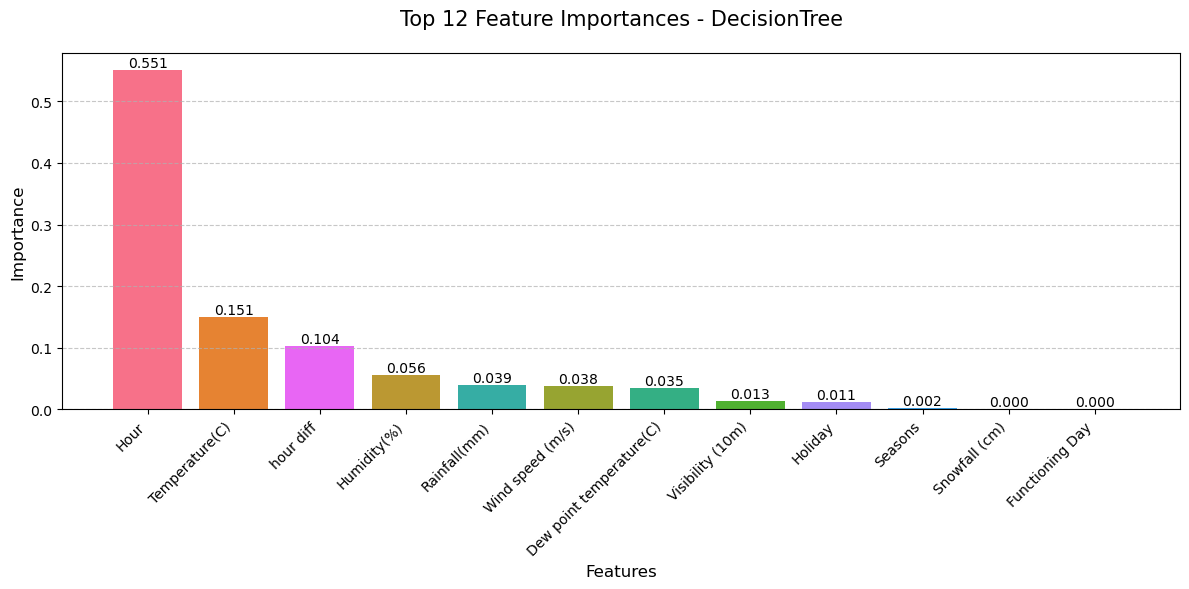

DecisionTree - MSE: 3425.1979, RMSE: 58.5252, R2: 0.9997
🏃 View run DecisionTree at: http://mlflow.mlflow:5000/#/experiments/2/runs/d2971480fe2a4bd98bb401342777e233
🧪 View experiment at: http://mlflow.mlflow:5000/#/experiments/2


2025/07/01 11:57:12 INFO mlflow.system_metrics.system_metrics_monitor: Stopping system metrics monitoring...
2025/07/01 11:57:13 INFO mlflow.system_metrics.system_metrics_monitor: Successfully terminated system metrics monitoring!
2025/07/01 11:57:13 INFO mlflow.system_metrics.system_metrics_monitor: Skip logging GPU metrics. Set logger level to DEBUG for more details.
2025/07/01 11:57:13 INFO mlflow.system_metrics.system_metrics_monitor: Started monitoring system metrics.
2025/07/01 11:57:13 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/opt/conda/lib/python3.11/site-packages/mlflow/types/utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample

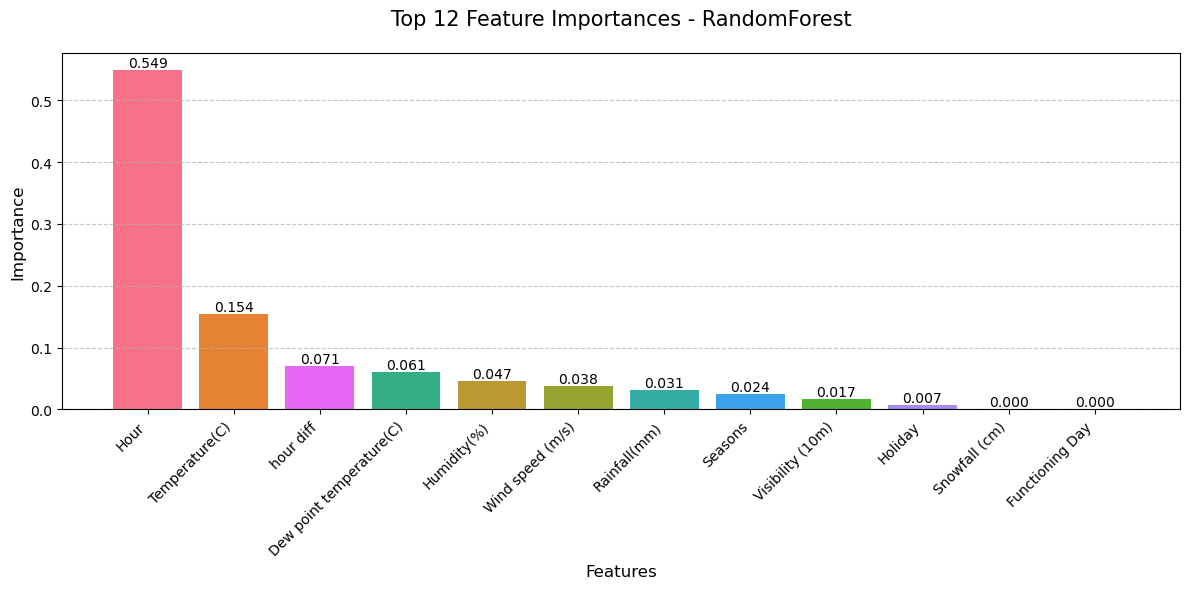

RandomForest - MSE: 531383.1884, RMSE: 728.9603, R2: 0.9552
🏃 View run RandomForest at: http://mlflow.mlflow:5000/#/experiments/2/runs/6206c371c4484d46893a1e158624bcb1
🧪 View experiment at: http://mlflow.mlflow:5000/#/experiments/2


2025/07/01 11:57:21 INFO mlflow.system_metrics.system_metrics_monitor: Stopping system metrics monitoring...
2025/07/01 11:57:21 INFO mlflow.system_metrics.system_metrics_monitor: Successfully terminated system metrics monitoring!
2025/07/01 11:57:21 INFO mlflow.system_metrics.system_metrics_monitor: Skip logging GPU metrics. Set logger level to DEBUG for more details.
2025/07/01 11:57:21 INFO mlflow.system_metrics.system_metrics_monitor: Started monitoring system metrics.
2025/07/01 11:57:22 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/opt/conda/lib/python3.11/site-packages/mlflow/types/utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample

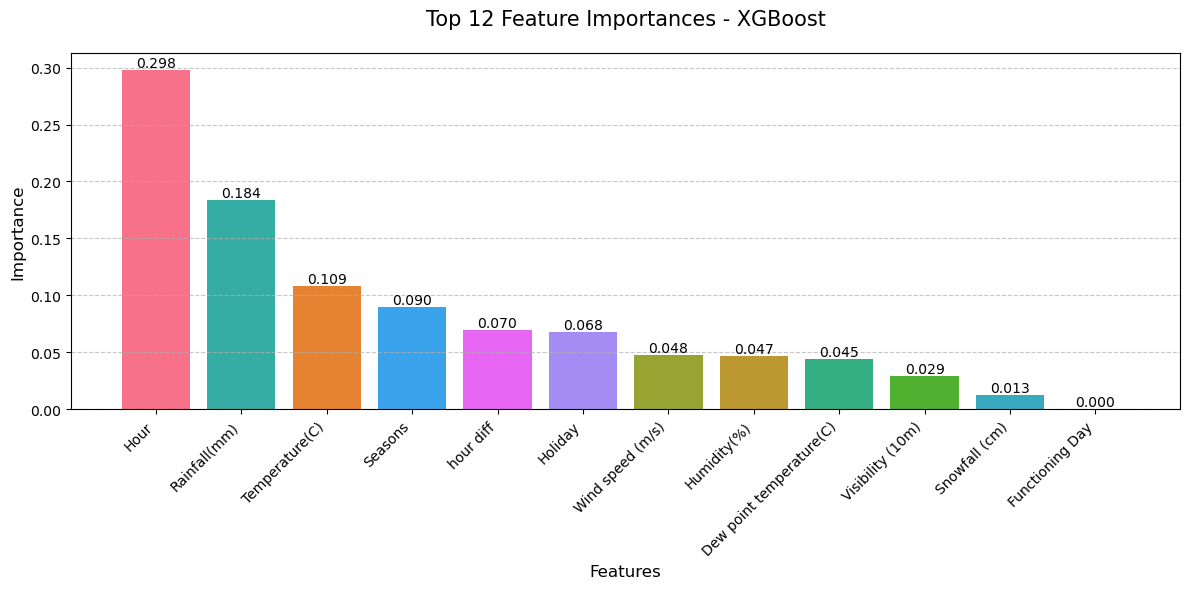

XGBoost - MSE: 146548.0043, RMSE: 382.8159, R2: 0.9876
🏃 View run XGBoost at: http://mlflow.mlflow:5000/#/experiments/2/runs/b9628b34bc164d518601be5da3cb1335
🧪 View experiment at: http://mlflow.mlflow:5000/#/experiments/2


2025/07/01 11:57:29 INFO mlflow.system_metrics.system_metrics_monitor: Stopping system metrics monitoring...
2025/07/01 11:57:29 INFO mlflow.system_metrics.system_metrics_monitor: Successfully terminated system metrics monitoring!


In [6]:
# 각 모델에 대해 학습 및 평가
for model_name, model in models.items():
    with mlflow.start_run(run_name=model_name):
        model.fit(X_train, y_train)
        
        y_pred = model.predict(X_test)
        
        mse = mean_squared_error(y_test, y_pred)
        rmse = np.sqrt(mse)
        r2 = r2_score(y_test, y_pred)
        
        # MLflow에 메트릭 기록
        mlflow.log_metric("MSE", mse)
        mlflow.log_metric("RMSE", rmse)
        mlflow.log_metric("R2", r2)
        
        # 모델 파라미터 기록
        mlflow.log_params(model.get_params())
        # mlflow.sklearn.log_model(sk_model=model, name=model_name)
        
        importances = None
        if model_name == "RandomForest":
            importances = model.feature_importances_
        elif model_name == "XGBoost":
            importances = model.feature_importances_
        elif model_name == "DecisionTree":
            importances = model.feature_importances_
        
        if importances is not None:
            feature_imp = pd.DataFrame({
                'feature': X_train.columns,
                'importance': importances
            }).sort_values('importance', ascending=False)

            feature_imp.to_csv(f"{model_name}_feature_importance.csv", index=False)
            mlflow.log_artifact(f"{model_name}_feature_importance.csv")

            plot_feature_importance(model_name, feature_imp, top_n=len(features))
        
        print(f"{model_name} - MSE: {mse:.4f}, RMSE: {rmse:.4f}, R2: {r2:.4f}")

In [7]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import numpy as np

mse = mean_squared_error(y, y_predict)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y, y_predict)
r2 = r2_score(y, y_predict)

print(f'MSE: {mse:.4f}')
print(f'RMSE: {rmse:.4f}')
print(f'MAE: {mae:.4f}')
print(f'R2 Score: {r2:.4f}')

NameError: name 'y' is not defined

2025/07/01 11:58:53 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/opt/conda/lib/python3.11/site-packages/mlflow/types/utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details."
2025/07/01 11:58:54 INFO mlflow.system_metrics.system_metrics_monitor: Skip logging GPU metrics. Set logger level to DEBUG for more details.
2025/07/01 11:58:54 

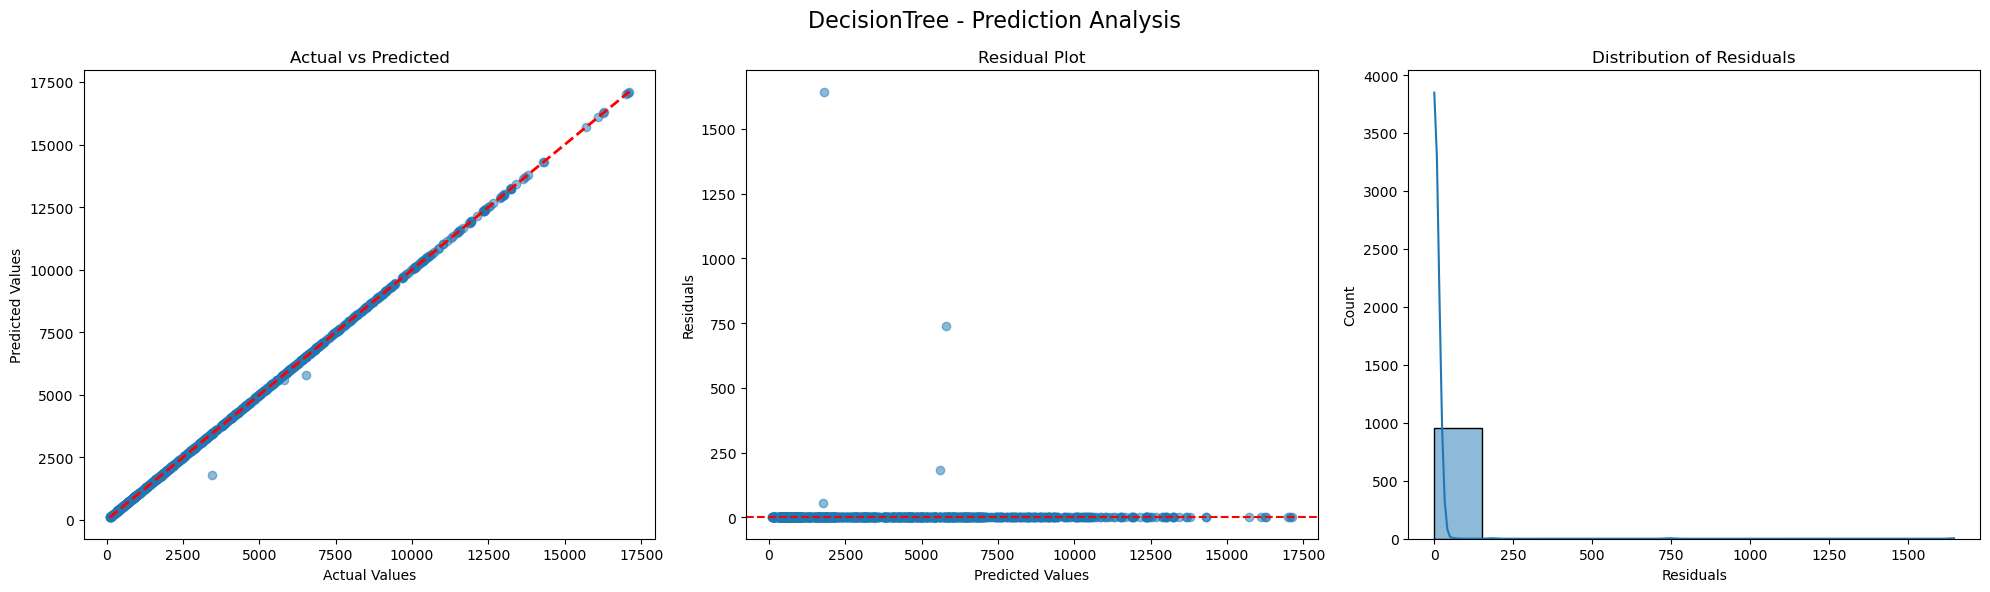

2025/07/01 11:58:55 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/opt/conda/lib/python3.11/site-packages/mlflow/types/utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details."


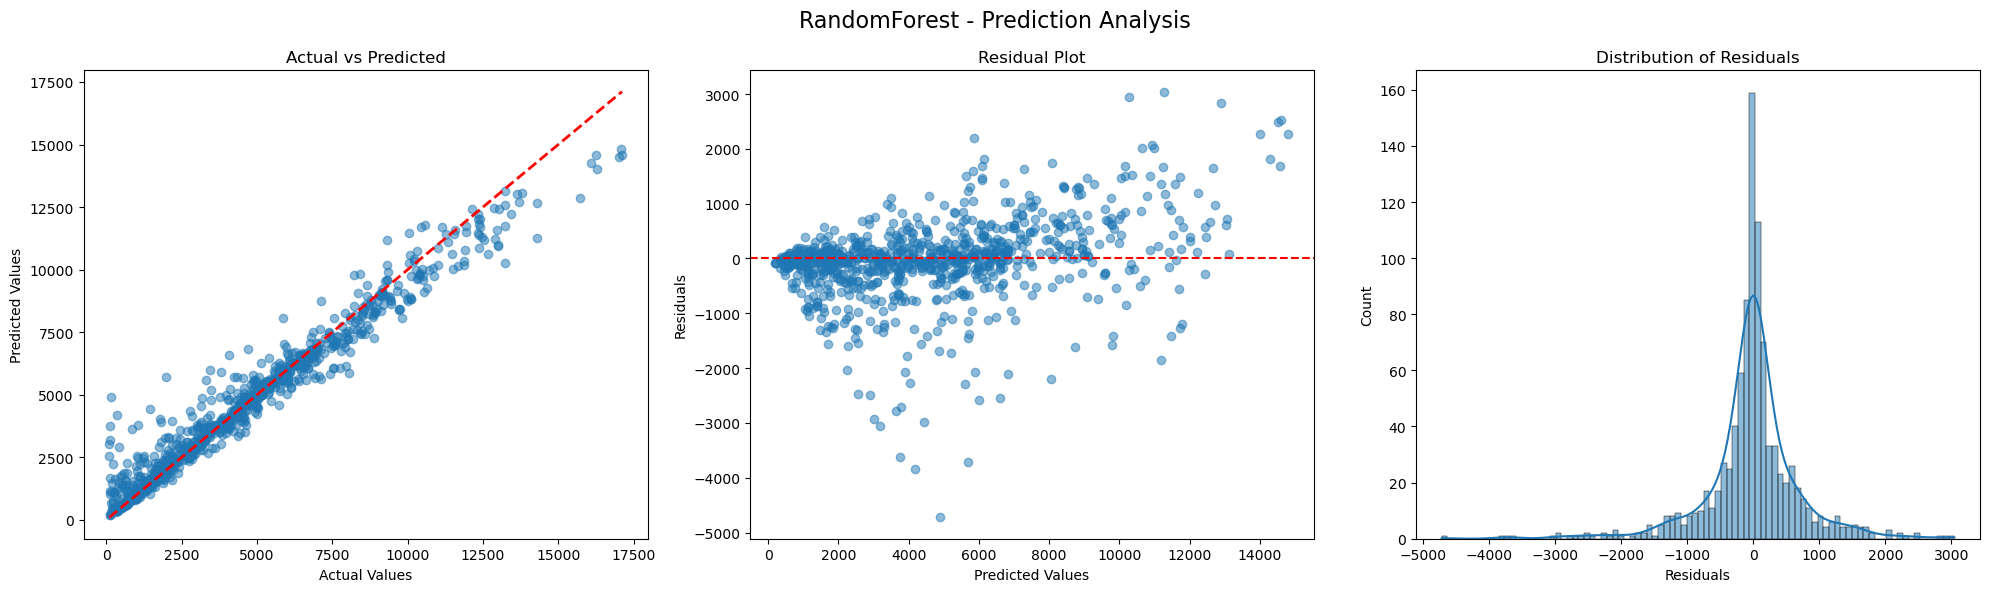

2025/07/01 11:58:56 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/opt/conda/lib/python3.11/site-packages/mlflow/types/utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details."


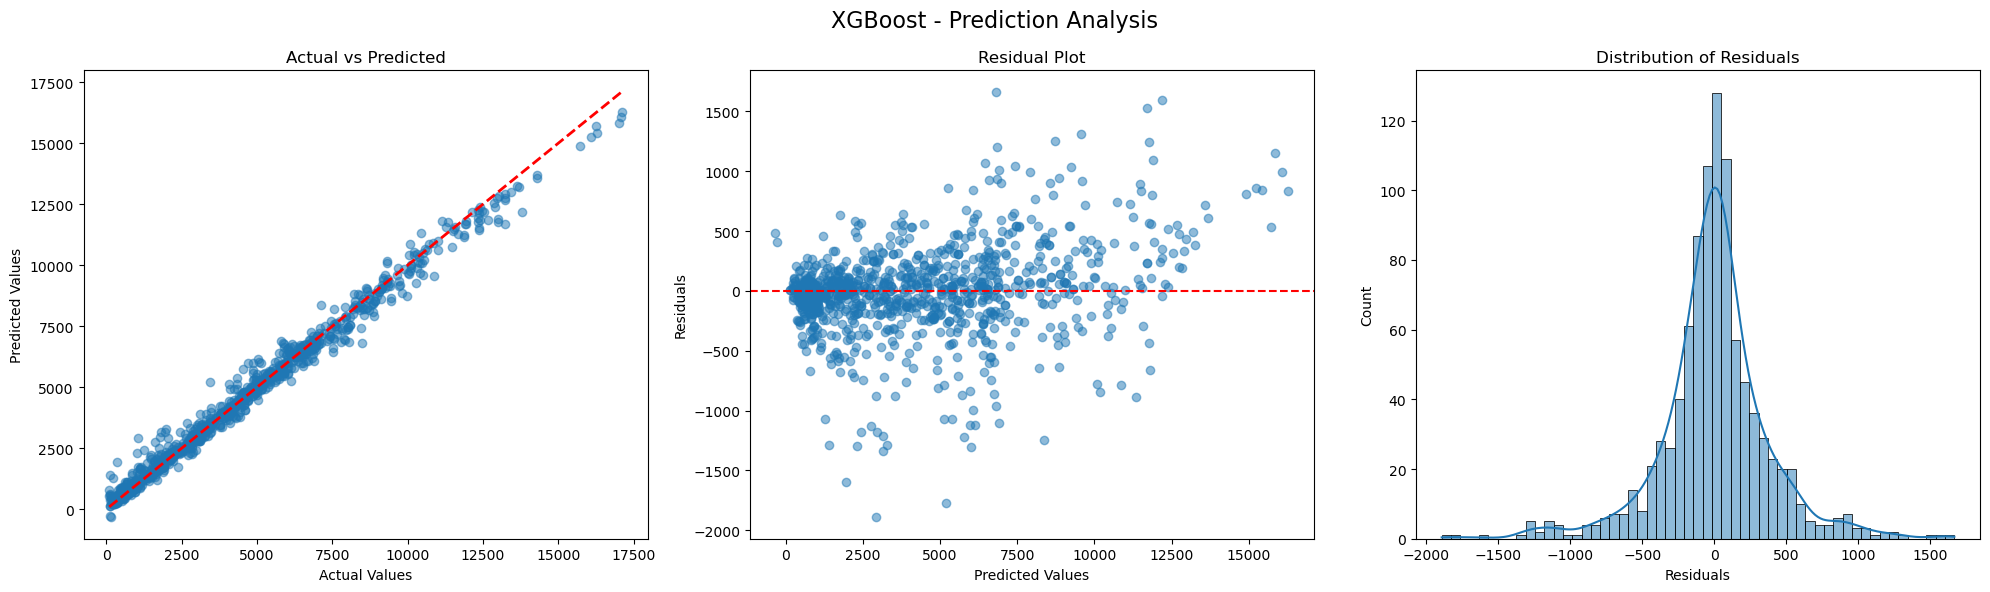

🏃 View run efficient-eel-394 at: http://mlflow.mlflow:5000/#/experiments/2/runs/4f3ba86940134263b891f22f56891b36
🧪 View experiment at: http://mlflow.mlflow:5000/#/experiments/2


2025/07/01 11:58:58 INFO mlflow.system_metrics.system_metrics_monitor: Stopping system metrics monitoring...
2025/07/01 11:58:59 INFO mlflow.system_metrics.system_metrics_monitor: Successfully terminated system metrics monitoring!


In [10]:
for model_name, model in models.items():
    y_pred = model.predict(X_test)
    fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(20, 6))
    
    # 1. 산점도
    ax1.scatter(y_test, y_pred, alpha=0.5)
    ax1.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
    ax1.set_xlabel('Actual Values')
    ax1.set_ylabel('Predicted Values')
    ax1.set_title('Actual vs Predicted')

    # 2. 잔차 플롯
    residuals = y_test - y_pred
    ax2.scatter(y_pred, residuals, alpha=0.5)
    ax2.axhline(y=0, color='r', linestyle='--')
    ax2.set_xlabel('Predicted Values')
    ax2.set_ylabel('Residuals')
    ax2.set_title('Residual Plot')

    # 3. 잔차 분포
    sns.histplot(residuals, ax=ax3, kde=True)
    ax3.set_xlabel('Residuals')
    ax3.set_ylabel('Count')
    ax3.set_title('Distribution of Residuals')
    
    
    plt.suptitle(f'{model_name} - Prediction Analysis', fontsize=16)
    plt.tight_layout()
    
    # 저장 및 표시
    plt.savefig(f"{model_name}_prediction_analysis.png", dpi=300, bbox_inches='tight')
    mlflow.log_artifact(f"{model_name}_prediction_analysis.png")
    
    # Jupyter Notebook에 표시
    plt.show()
    
    # 메모리 정리
    plt.close()

mlflow.end_run()